In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv("data.csv")
labels = pd.read_csv("labels.csv")

In [3]:
data.head()

,Unnamed: 0,k__Viruses.f__Phycodnaviridae.g__Prasinovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Sfi1unalikevirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Simplexvirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__C2likevirus,k__Viruses.f__Poxviridae.g__Parapoxvirus,k__Viruses.f__Papillomaviridae.g__Dyolambdapapillomavirus,k__Viruses.o__Mononegavirales.f__Bornaviridae.g__Bornavirus,k__Viruses.f__Bicaudaviridae.g__Bicaudavirus,k__Viruses.o__Picornavirales.f__Picornaviridae.g__Aquamavirus,...,k__Bacteria.p__Synergistetes.c__Synergistia.o__Synergistales.f__Synergistaceae.g__Cloacibacillus,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Sellimonas,k__Archaea.p__Thaumarchaeota.g__Candidatus_Nitrosotenuis,k__Bacteria.p__Rhodothermaeota.c__Balneolia.o__Balneolales.f__Balneolaceae.g__Gracilimonas,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Thermoproteales.f__Thermoproteaceae.g__Caldivirga,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_Family_XIII._Incertae_Sedis.g__Casaltella,k__Archaea.p__Crenarchaeota.c__Thermoprotei.o__Desulfurococcales.f__Desulfurococcaceae.g__Thermosphaera,k__Bacteria.p__Proteobacteria.c__Betaproteobacteria.o__Neisseriales.f__Chromobacteriaceae.g__Deefgea,k__Bacteria.p__Deferribacteres.c__Deferribacteres.o__Deferribacterales.f__Deferribacteraceae.g__Geovibrio,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Subdoligranulum
0,s12859,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,s12878,0,0,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,s12857,2,0,484,0,8,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
3,s12882,4,0,96,0,2,0,0,2,4,...,0,0,0,0,0,0,0,0,0,0
4,s12871,2,0,128,0,16,0,4,0,4,...,0,0,0,0,0,0,0,0,0,0


In [4]:
labels.head()

,Sample,disease_type
0,s12859,colon cancer
1,s12878,colon cancer
2,s12857,colon cancer
3,s12882,colon cancer
4,s12871,colon cancer


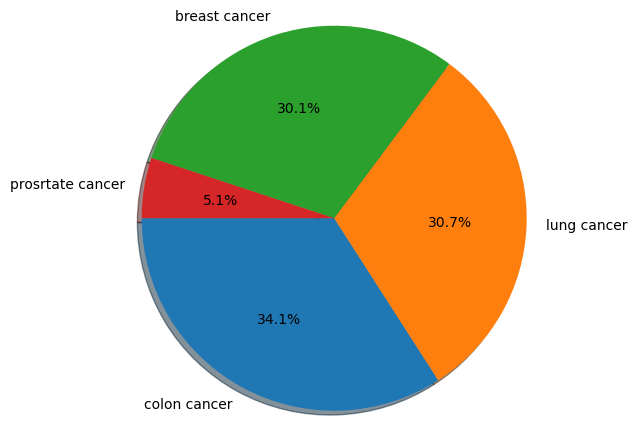

In [5]:
plt.figure( figsize= (5,5))
plt.pie((labels.disease_type.value_counts())/100 , labels=pd.unique(labels.disease_type), startangle
=180 , autopct='%1.1f%%' ,textprops={ 'fontsize': 10 , 'rotation':0}, shadow=True, radius=1.25)
plt.show()

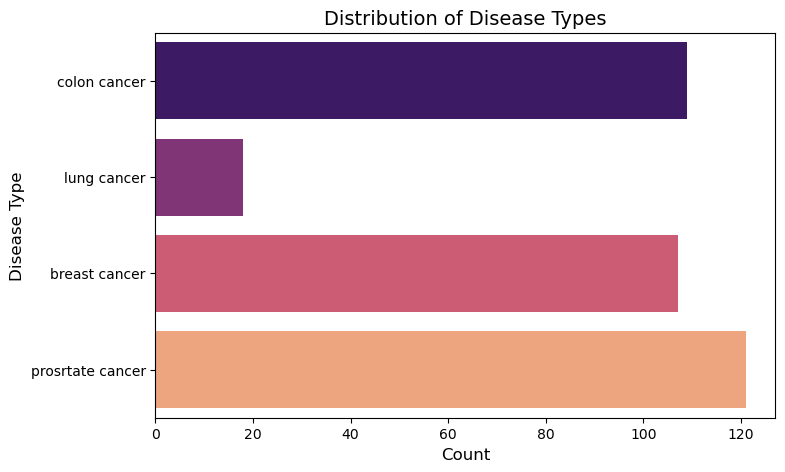

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(y=labels.disease_type, hue=labels.disease_type, palette='magma', dodge=False, legend=False)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Disease Type', fontsize=12)
plt.title('Distribution of Disease Types', fontsize=14)
plt.show()

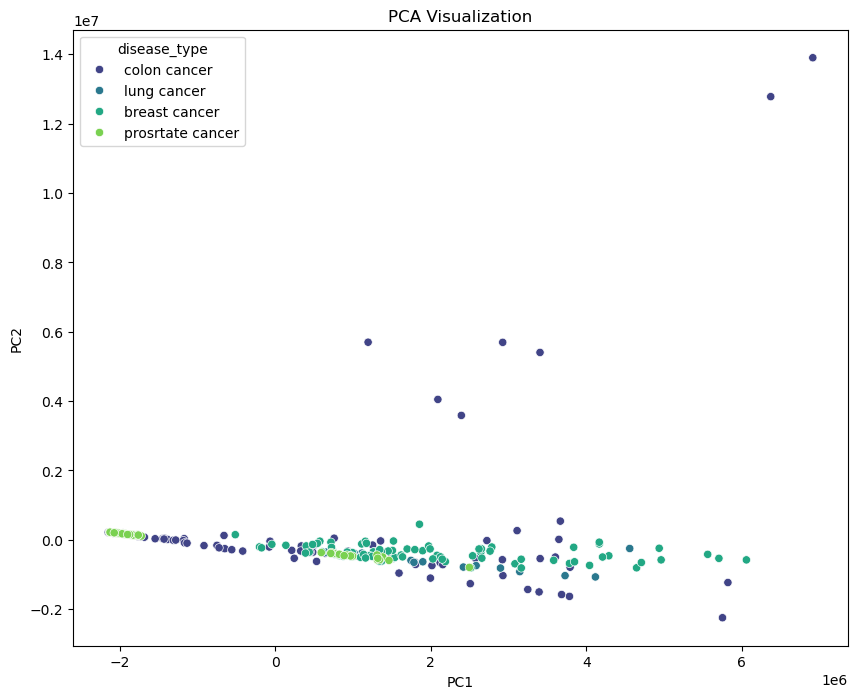

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data.iloc[:, 1:])
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

final_df = pd.concat([principal_df, labels['disease_type']], axis=1)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='disease_type', data=final_df, palette='viridis')
plt.title('PCA Visualization')
plt.show()

# RANDOM FOREST

In [8]:
X = data.drop(['Unnamed: 0'], axis=1)
y = labels.disease_type

In [9]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100],
    'max_features': [7, 19, 21],
    'min_samples_split': [3, 7, 11],
    'max_depth': [3, 7, 11]
}

In [12]:
# StratifiedKFold kullanarak çapraz doğrulama stratejisini belirle
cv = StratifiedKFold(n_splits=3)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': 11, 'max_features': 21, 'min_samples_split': 3, 'n_estimators': 100}
Best accuracy: 0.9647629712579321


In [13]:
best_params_rf = grid_search.best_params_

In [14]:
rf = RandomForestClassifier(max_depth=best_params_rf['max_depth'], 
                            max_features=best_params_rf['max_features'], 
                            min_samples_split=best_params_rf['min_samples_split'], 
                            n_estimators=best_params_rf['n_estimators'])
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, max_features=21, min_samples_split=3)

In [15]:
y_pred = rf.predict(X_test)

In [16]:
accuracy_score(y_test, y_pred)

0.9436619718309859

In [17]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Random Forest CV Accuracy:", cross_val_score(rf, X_test, y_test, cv=3).mean())
print(classification_report_imbalanced(y_test, y_pred, target_names=label_encoder.classes_))

Random Forest Accuracy: 0.9436619718309859


\\?\C:\Users\erens\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Random Forest CV Accuracy: 0.8580917874396135
                        pre       rec       spe        f1       geo       iba       sup

   breast cancer       1.00      0.83      1.00      0.91      0.91      0.82        18
    colon cancer       0.93      0.96      0.96      0.94      0.96      0.92        26
     lung cancer       1.00      1.00      1.00      1.00      1.00      1.00         2
prosrtate cancer       0.93      1.00      0.96      0.96      0.98      0.96        25

     avg / total       0.95      0.94      0.97      0.94      0.95      0.91        71



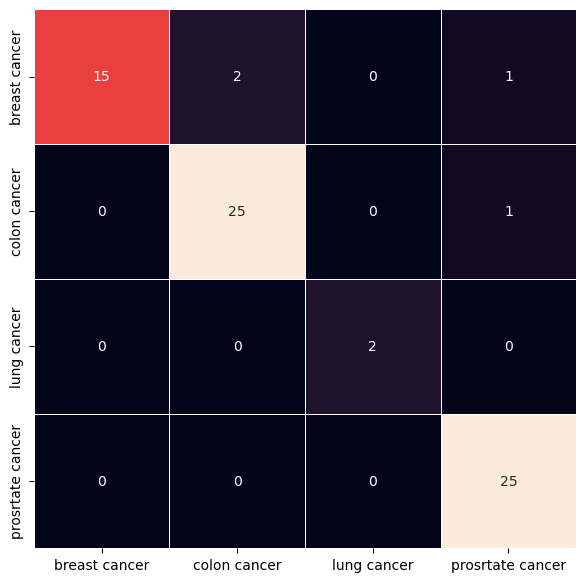

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7, cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.show()


# test 

from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
gbm_params = {'learning_rate': [0.1, 0.01, 0.05],
            'n_estimators': [100,200],
            'max_depth':[2,3,5,8]}

gbm_cv_model = GridSearchCV(gbm, gbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

gbm_cv_model

best_params_gbm = gbm_cv_model.best_params_

gbm = GradientBoostingClassifier(
    learning_rate=best_params_gbm['learning_rate'], 
    max_depth=best_params_gbm['max_depth'], 
    n_estimators=best_params_gbm['n_estimators']).fit(X_train, y_train)

y_pred = gbm.predict(X_test)

accuracy_score(y_test, y_pred)

# XGBoost

# fix 

print("Gerçek Etiketler:", y_test)
print("Tahminler:", y_pred_single_class)

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [22]:
# XGBoost
xgboost = XGBClassifier()
xgboost_params = {'learning_rate': [0.1, 0.01, 0.001],
                  'subsample': [0.6, 0.8, 1],
                  'n_estimators': [100, 500],
                  'max_depth': [3, 5, 7]}

In [23]:
xgboost_cv_model = GridSearchCV(xgboost, xgboost_params, cv=10, n_jobs=-1, verbose=2)
xgboost_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 500],
                         'subsample': [0.6, 0.8, 1]},
             verbose=2)

In [24]:
print("Best parameters:", xgboost_cv_model.best_params_)
print("Best accuracy:", xgboost_cv_model.best_score_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}
Best accuracy: 0.9964285714285716


In [25]:
# Fit XGBoost model with best parameters
best_params_xgb = xgboost_cv_model.best_params_
xgboost = XGBClassifier(learning_rate=best_params_xgb['learning_rate'],
                        max_depth=best_params_xgb['max_depth'],
                        n_estimators=best_params_xgb['n_estimators'],
                        subsample=best_params_xgb['subsample'])
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
# Predictions and evaluation
y_pred = xgboost.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("XGBoost CV Accuracy:", cross_val_score(xgboost, X_test, y_test, cv=10).mean())

XGBoost Accuracy: 1.0


\\?\C:\Users\erens\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


XGBoost CV Accuracy: 0.9160714285714284


In [27]:
# Sensitivity and specificity
sens_spec = sensitivity_specificity_support(y_test, y_pred, average='micro', labels=np.unique(y_encoded))
print("Sensitivity and Specificity:", sens_spec)

Sensitivity and Specificity: (1.0, 1.0, None)


In [28]:
# Classification report
print(classification_report_imbalanced(y_test, y_pred, target_names=label_encoder.classes_))

                        pre       rec       spe        f1       geo       iba       sup

   breast cancer       1.00      1.00      1.00      1.00      1.00      1.00        18
    colon cancer       1.00      1.00      1.00      1.00      1.00      1.00        26
     lung cancer       1.00      1.00      1.00      1.00      1.00      1.00         2
prosrtate cancer       1.00      1.00      1.00      1.00      1.00      1.00        25

     avg / total       1.00      1.00      1.00      1.00      1.00      1.00        71



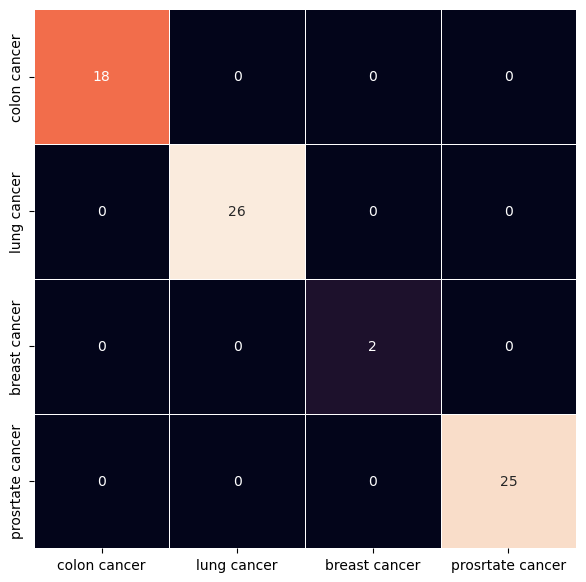

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.7 ,cbar=False, xticklabels=pd.unique(labels.disease_type),yticklabels=pd.unique(labels.disease_type))
plt.show()

# Conclusion

In [32]:
models = [rf, xgboost]
results = pd.DataFrame(columns=['Models', "Accuracy"])

for model in models:
    names = model.__class__.__name__
    print(names)
    if names == 'MLPClassifier':
        y_pred = model.predict(X_test_scaler)
    else:
        y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    result = pd.DataFrame([[names, acc*100]], columns=['Models', 'Accuracy'])
    results = pd.concat([results, result], ignore_index=True)  # Concatenate results DataFrame with new result

RandomForestClassifier
XGBClassifier


C:\Users\erens\AppData\Local\Temp\ipykernel_20880\1954998251.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result], ignore_index=True)  # Concatenate results DataFrame with new result


,Models,Accuracy
0,RandomForestClassifier,94.366197
1,XGBClassifier,100.000000


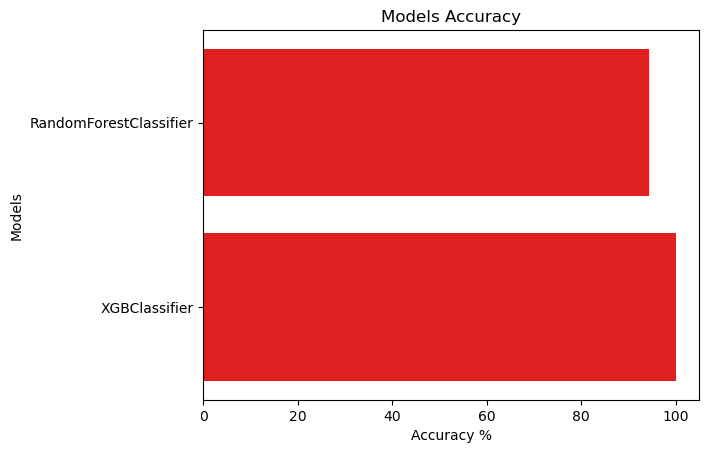

In [36]:
sns.barplot(x='Accuracy', y='Models', data=results, color='r')
plt.xlabel('Accuracy %')
plt.title('Models Accuracy');

results